In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

INPUT = '/scratch/users/k21075402/new/commons_harvest__open/'
TRIAL_IDS = ['39596646', '3f82a7f6', 'd1a59a0e', 'ebcd23ed']

In [2]:
def load_df(trial_id):
    df = pd.read_json(os.path.join(INPUT, trial_id, 'results.json'), lines=True)
    df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
    df['iteration'] = df.training_iteration + 300 * (df.num_players - 1)
    df['trial_id'] = trial_id
    df = df.drop(columns=['training_iteration', 'episode_reward', 'episode_lengths', 'policy_default_reward'])
    return df

df = pd.concat([load_df(t) for t in TRIAL_IDS])
    

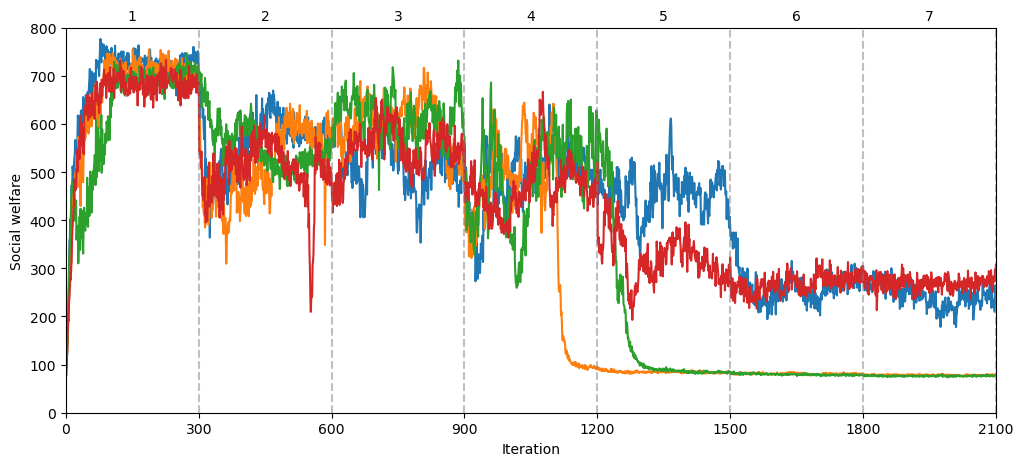

In [4]:
# Group by the 'Category' column
grouped = df.groupby('trial_id')

# Plot each group
fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
for name, group in grouped:
    group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False)

# Add legend and labels
# ax.legend(title='Trial ID')
ax.set_xlabel('Iteration')
ax.set_ylabel('Social welfare')
# ax.set_title('WIP')
ax.set_xlim(0, 2100)
ax.set_ylim(0, 800)
ax.set_xticks(np.arange(0, 2101, 300))

regions = dict((str(i), i * 300) for i in range(1,8))

for region, position in regions.items():
    ax.axvline(x=position, color='gray', linestyle='--', alpha=0.5)
    ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')



# edges = [e for e in range(0, 2+7*300, 300)]

# # Add vertical lines for each edge
# for edge in edges:
#     ax.axvline(x=edge, color='gray', linestyle='--', alpha=0.5)

# # Add labels for regions in the middle of the edges
# region_labels = [i for i in range(1, 8)]
# for i, label in enumerate(region_labels):
#     mid_point = (edges[i] + edges[i + 1]) / 2
#     ax.text(mid_point, 1.02, label, transform=ax.get_xaxis_transform(), horizontalalignment='center')

In [5]:
fig.savefig('runs')


In [ ]:
# get trial id, training iteration, reward